In [ ]:
import scanpy
import numpy as np
import pandas as pd

import mnmstpy as mnmst

In [2]:
import scanpy as sc

adata = sc.read_visium(path='D:/st_projects/data/DLPFC/151507', count_file='151507_filtered_feature_bc_matrix.h5')

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000)
hvg_filter = adata.var['highly_variable']
sc.pp.normalize_total(adata, inplace=True)
adata = adata[:, hvg_filter]
display(adata)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 4226 × 3002
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg'
    obsm: 'spatial'

In [5]:
enhanced_adata, cell_spatial = mnmst.data_enhance(adata, k_nei=6)


Median distance to closest cell = 138.0
num_nbrs: 3002


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
sc.pp.pca(enhanced_adata)
low_dim_x = enhanced_adata.obsm['X_pca']

In [7]:
init_graph = mnmst.construct_initial_graph(low_dim_x)

In [8]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
cos_init_tensor = torch.from_numpy(init_graph).float().to(device)
x_tensor = torch.from_numpy(low_dim_x.T).to(device)
C_gpu = mnmst.sparse_self_representation_torch(x_tensor, init_w=cos_init_tensor, alpha=1., beta=1., device=device)
spatia_init_tensor = torch.from_numpy(cell_spatial.A).float().to(device)
Z_gpu = mnmst.MNMST_representation_gpu(C_gpu, spatia_init_tensor, device=device)

# Epoch 19, loss: 0.105:  20%|██        | 20/100 [00:02<00:11,  7.19it/s]


In [9]:
from sklearn.cluster import SpectralClustering

n_clusters = 7  # 你可以根据需要设置聚类的数量
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(Z_gpu.detach().cpu().numpy())

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(


C:\Users\wangyu\AppData\Local\Temp\ipykernel_54156\945947562.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['spe_pred'] = labels
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = p

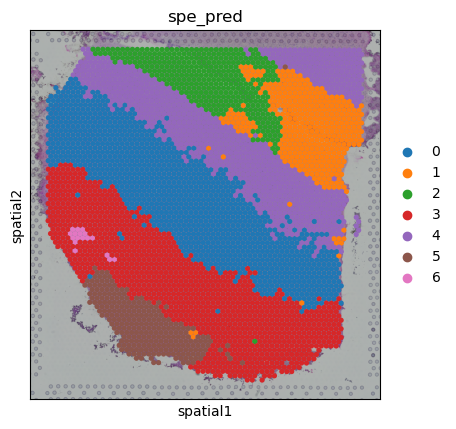

In [10]:
adata.obs['spe_pred'] = labels
adata.obs["spe_pred"] = adata.obs["spe_pred"].astype('int')
adata.obs['spe_pred'] = adata.obs['spe_pred'].astype('category')
sc.pl.spatial(adata, color=['spe_pred'], size=1.5)

In [11]:
C = mnmst.sparse_self_representation(low_dim_x.T, init_w=init_graph)
Z = mnmst.MNMST_representation(C, cell_spatial)

# Epoch 0, loss: 641.738:   1%|          | 1/100 [00:01<02:40,  1.62s/it]D:\st_projects\MNMST-package\src\mnmstpy\network.py:66: RuntimeWarning: divide by zero encountered in divide
  C = C * ((x.T @ x + mu * (J1 - np.diag(np.diag(J1))) - T1 + beta * init_w @ C) /
D:\st_projects\MNMST-package\src\mnmstpy\network.py:66: RuntimeWarning: invalid value encountered in multiply
  C = C * ((x.T @ x + mu * (J1 - np.diag(np.diag(J1))) - T1 + beta * init_w @ C) /
# Epoch 28, loss: 0.102:  29%|██▉       | 29/100 [03:55<09:37,  8.13s/it] 


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=17.
  warnings.warn(
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


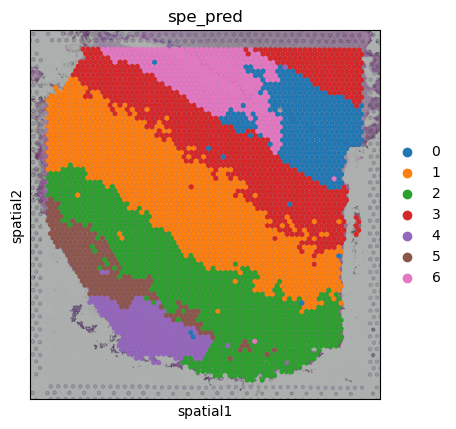

In [12]:

n_clusters = 7  # 你可以根据需要设置聚类的数量
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed')
labels = spectral.fit_predict(Z)
adata.obs['spe_pred'] = labels
adata.obs["spe_pred"] = adata.obs["spe_pred"].astype('int')
adata.obs['spe_pred'] = adata.obs['spe_pred'].astype('category')
sc.pl.spatial(adata, color=['spe_pred'], size=1.5)